In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline

from sklearn.utils import shuffle
import pickle
import sys
import cv2


import scipy as sp
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import StandardScaler

from time import time
import logging


In [2]:
#load data 
y_d=pickle.load(open("saved/y.p","rb"))
X_d=pickle.load(open("saved/X.p","rb"))

In [3]:
#organize data into dataframes
#to save computational time at this point, we'll use the cropped images
X_v_crop_d={}

for each in X_d.items():
    X_v_crop_d.update({each[0]:each[1][31:63,31:63].flatten()})

In [4]:
X_v_crop_df=pd.DataFrame.from_dict(X_v_crop_d,orient='index')

In [5]:
Xy_crop_df=X_v_crop_df.merge(y_d,right_on='id',left_index=True)

In [6]:
Xy_crop_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3064,3065,3066,3067,3068,3069,3070,3071,id,label
0,244,243,245,245,247,248,245,247,248,244,...,249,245,248,247,243,245,244,240,f38a6374c348f90b587e046aac6079959adf3835,0
1,253,252,254,250,247,249,234,231,233,255,...,249,249,249,249,249,248,250,250,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,184,174,187,195,162,189,177,148,174,173,...,199,226,168,160,183,199,193,212,755db6279dae599ebb4d39a9123cce439965282d,0
3,173,106,173,218,139,206,172,98,158,191,...,85,145,177,106,169,191,118,186,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,74,36,66,82,39,96,212,178,242,119,...,20,80,105,64,121,77,27,81,068aba587a4950175d04c680d38943fd488d6a9d,0


Recall from the Baseline Model that a simple logistic regression yielded mediocre results. We will try to more robust strategies here, a random forest and nerual net. For these, we are going to scale the data from pixel values of 0-255 to values of 0-1.

In [ ]:
#save DataFrame for later use
Xy_crop_df.to_csv('saved/Xy_crop.csv')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(Xy_crop_df.iloc[:,:3071].values,
                                                Xy_crop_df.label.values,
                                                stratify=Xy_crop_df.label.values)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
scaler.fit(X_train)  
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

Now that we are ready, we will use the following to find the best classifier:
* Try a Random Forest with default settings
* Try a Neural Net with default settings
* Try tuning hyperparaeters for both to improve results
As noted in the Baseline Model notebook, we will be using the area under the ROC curve to evaluate these classifiers.

Hyperparameters for tuning random forest will be:
* n_estimators
* max_features
* criterion

Hyperparameters for tuning MLP Classifier will be:
* beta_1 & beta_2 for adam solver
* learning_rate
* learning rate int
* max_iter

In [14]:
#Random Forest
# Create the model with 100 trees

model = RandomForestClassifier(verbose=1,n_jobs=-1)
# Fit on training data
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

Classification Report (test):


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    1.0s finished


              precision    recall  f1-score   support

           0       0.76      0.88      0.81     32727
           1       0.77      0.60      0.67     22280

    accuracy                           0.76     55007
   macro avg       0.76      0.74      0.74     55007
weighted avg       0.76      0.76      0.76     55007

Confusion Matrix:


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.9s finished


[[28675  4052]
 [ 8989 13291]]


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.9s finished


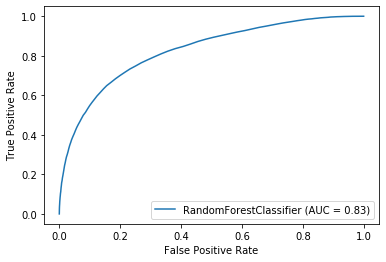

In [15]:
print('Classification Report (test):')
print(classification_report(y_test,model.predict(X_test)))
print('Confusion Matrix:')
print(confusion_matrix(y_test,model.predict(X_test)))
plot_roc_curve(model,X_test,y_test)
plt.show()

In [16]:
model = MLPClassifier(early_stopping=True,
                      verbose=True
                      )

model.fit(X_train, y_train)

Iteration 1, loss = 0.64174130
Validation score: 0.585990
Iteration 2, loss = 0.62756003
Validation score: 0.594958
Iteration 3, loss = 0.61969717
Validation score: 0.611380
Iteration 4, loss = 0.61499799
Validation score: 0.620591
Iteration 5, loss = 0.61156901
Validation score: 0.625318
Iteration 6, loss = 0.60957544
Validation score: 0.637680
Iteration 7, loss = 0.60625682
Validation score: 0.644225
Iteration 8, loss = 0.60413428
Validation score: 0.647376
Iteration 9, loss = 0.60037225
Validation score: 0.652406
Iteration 10, loss = 0.59734216
Validation score: 0.657132
Iteration 11, loss = 0.59737790
Validation score: 0.661071
Iteration 12, loss = 0.59358662
Validation score: 0.643134
Iteration 13, loss = 0.59275138
Validation score: 0.653981
Iteration 14, loss = 0.59036856
Validation score: 0.664889
Iteration 15, loss = 0.58964041
Validation score: 0.665010
Iteration 16, loss = 0.58749087
Validation score: 0.665919
Iteration 17, loss = 0.58696379
Validation score: 0.664162
Iterat

/home/morganfry42/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

Classification Report (test):
              precision    recall  f1-score   support

           0       0.75      0.72      0.73     32727
           1       0.61      0.65      0.63     22280

    accuracy                           0.69     55007
   macro avg       0.68      0.68      0.68     55007
weighted avg       0.69      0.69      0.69     55007

Confusion Matrix:
[[23428  9299]
 [ 7725 14555]]


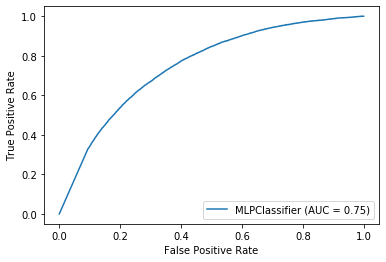

In [17]:
pred=model.predict(X_test)
print('Classification Report (test):')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(model,X_test,y_test)
plt.show()

In [12]:
from sklearn.model_selection import RandomizedSearchCV

#parameters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 3000, num = 6)]
max_features = ['sqrt','log2']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True]
criterion = ['entropy']

params={'n_estimators': n_estimators,
        'max_features': max_features,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap,
        'criterion': criterion}

In [20]:
rfc=RandomForestClassifier()

rf_rand=RandomizedSearchCV(estimator=rfc, 
                           param_distributions=params, 
                           cv=2,
                           verbose=1, 
                           n_jobs=-1,
                           return_train_score=True)
rf_rand.fit(X_test,y_test)
rf_rand.cv_results_

ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

In [ ]:
rf_rand.best_params_

In [ ]:
#now plug best parameters into the random forest
model = RandomForestClassifier(n_estimators=2000,
                               max_features='sqrt',
                               criterion='entropy',
                               verbose=1,n_jobs=-1)
# Fit on training data
model.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.3min


In [ ]:
pred=model.predict(X_test)
print('Classification Report (test):')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(model,X_test,y_test)
plt.show()

Seems that's as good as we'll get with the random forest, so let's see how a neural net does